# 2 MNIST classification

In [14]:
#2.1 Loading the MNIST dataset

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import optimizers

(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
#tfds.show_examples(train_ds , ds_info)


# 2.2 Setting up the data pipeline

def data_pipeline(input, batch_size=64, prefetch_buffer_size=4):
    # Map the dataset to extract images and labels
    input =input.map(lambda image, label: (image, label))
    # Reshape each image to a flat vector
    input = input.map(lambda image, label: (tf.reshape(image, (-1,)), label))
    # Normalize(Scale) image values to be in the range [-1, 1]
    input = input.map(lambda image, label: ((tf.cast(image, tf.float32) / 128) - 1, label))
    # One-hot encode the labels
    input = input.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
    # Shuffle the dataset and create batches of size 4
    input = input.shuffle(1024).batch(batch_size)
    # Prefetch the dataset to improve pipeline performance
    input = input.prefetch(prefetch_buffer_size)
    return input

# Save the datasets after applying the data pipeline
train_dataset = data_pipeline(train_ds)
test_dataset = data_pipeline(test_ds)

for elem in train_dataset.take(1):
    print(elem)

for elem in test_dataset.take(1):
    print(elem)


# 2.3 Building a deep neural network with TensorFlow
class MLPModel(tf.keras.Model):
    def __init__(self, layer_sizes=[256, 256], output_size=10):
        super().__init__()
        self.mlp_layers = []  # create a list to store hidden layers

        # Create hidden layers with ReLU activation
        for layer_size in layer_sizes:
            new_layer = layers.Dense(units=layer_size, activation='relu')
            self.mlp_layers.append(new_layer)
        # Output layer with softmax activation for classification
        self.output_layer = layers.Dense(units=output_size, activation='softmax')

    def call(self, x):
        # Forward pass through hidden layers
        for mlp_layer in self.mlp_layers:
            x = mlp_layer(x)
        # Forward pass through the output layer
        y = self.output_layer(x)
        return y

# 2.4 Training the network
"""
Define a training loop function which receives
• The number of epochs
• The model object
• The training dataset
• The test dataset
• The loss function
• The optimizer
• Different arrays for the different values you want to track for visualization
"""


def train_model(num_epochs, model, train_dataset, test_dataset, loss_function, optimizer, layer_sizes):
    train_losses = []
    test_losses = []
    train_accuracies = []  # Track training accuracy
    test_accuracies = []   # Track testing accuracy
    


    for epoch in range(num_epochs):
        epoch_train_losses = []
        correct_train_predictions = 0  # Counter for correct training predictions
        total_train_samples = 0

        # Training phase
        for x_train, target_train in train_dataset:
            with tf.GradientTape() as tape:
                # Forward pass
                pred_train = model(x_train)
                # Calculate the training loss
                loss_train = loss_function(target_train, pred_train)

            # Calculate gradients
            gradients_train = tape.gradient(loss_train, model.trainable_variables)

            # Update weights using optimizer
            optimizer.apply_gradients(zip(gradients_train, model.trainable_variables))

            # Append the training loss to the list
            epoch_train_losses.append(loss_train.numpy())

            # Calculate training accuracy
            correct_train_predictions += np.sum(np.argmax(target_train, axis=1) == np.argmax(pred_train, axis=1))
            total_train_samples += len(x_train)

        train_accuracy = correct_train_predictions / total_train_samples
        train_accuracies.append(train_accuracy)

        # Testing phase
        epoch_test_losses = []
        correct_test_predictions = 0  # Counter for correct testing predictions
        total_test_samples = 0

        for x_test, target_test in test_dataset:
            # Forward pass
            pred_test = model(x_test)
            # Calculate the testing loss
            loss_test = loss_function(target_test, pred_test)
            epoch_test_losses.append(loss_test.numpy())

            # Calculate testing accuracy
            correct_test_predictions += np.sum(np.argmax(target_test, axis=1) == np.argmax(pred_test, axis=1))
            total_test_samples += len(x_test)

        test_accuracy = correct_test_predictions / total_test_samples
        test_accuracies.append(test_accuracy)

        # Print the mean training and testing loss and accuracy for the epoch
        mean_train_loss = np.mean(epoch_train_losses)
        mean_test_loss = np.mean(epoch_test_losses)
        print(f"Epoch {epoch + 1},\n Train Loss: {mean_train_loss}, Train Accuracy: {train_accuracy},\n Test Loss: {mean_test_loss}, Test Accuracy: {test_accuracy}")

        # Append losses to the lists for visualization
        train_losses.append(mean_train_loss)
        test_losses.append(mean_test_loss)

    return train_losses, test_losses, train_accuracies, test_accuracies


# 2.5 Visualization
def plot_perhyper(hyperparam, method):
    unique_vals = results_df[hyperparam].unique()
    plt.figure(figsize=(12, 6))
    for i in unique_vals:
        subset = results_df[results_df[hyperparam] == i] 
        mean_metric = subset.groupby('epoch')[method].mean()  
        plt.plot(mean_metric, label=f"{hyperparam}:{i}")  

    plt.ylabel(method)
    plt.xlabel('Epochs')
    plt.title('Effect of Adjusting the hyperparameters of our model with different hyperparameters and methods')
    plt.legend()
    plt.show()


(<tf.Tensor: shape=(64, 784), dtype=float32, numpy=
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)>, <tf.Tensor: shape=(64, 10), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 

2023-11-22 14:40:50.050706: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-22 14:40:50.089374: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# 3 Hyperparameter Research
We will search for the the learning rate, batch size, the number and size of layers of your model and the optimizer


Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.38452181220054626, Train Accuracy: 0.8794833333333333,
 Test Loss: 0.2425629049539566, Test Accuracy: 0.927
Epoch 2,
 Train Loss: 0.170640230178833, Train Accuracy: 0.9475,
 Test Loss: 0.1556999236345291, Test Accuracy: 0.9532
Epoch 3,
 Train Loss: 0.1356545090675354, Train Accuracy: 0.9583333333333334,
 Test Loss: 0.12080734223127365, Test Accuracy: 0.9641
Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.3547934889793396, Train Accuracy: 0.89455,
 Test Loss: 0.21987271308898926, Test Accuracy: 0.9349
Epoch 2,
 Train Loss: 0.17644023895263672, Train Accuracy: 0.9478333333333333,
 Test Loss: 0.13756458461284637, Test Accuracy: 0.9603
Epoch 3,
 Train Loss: 0.13016310334205627, Train Accuracy: 0.9617666666666667,
 Test Loss: 0.1306976079940796, Test Accuracy: 0.962
Running experiment 

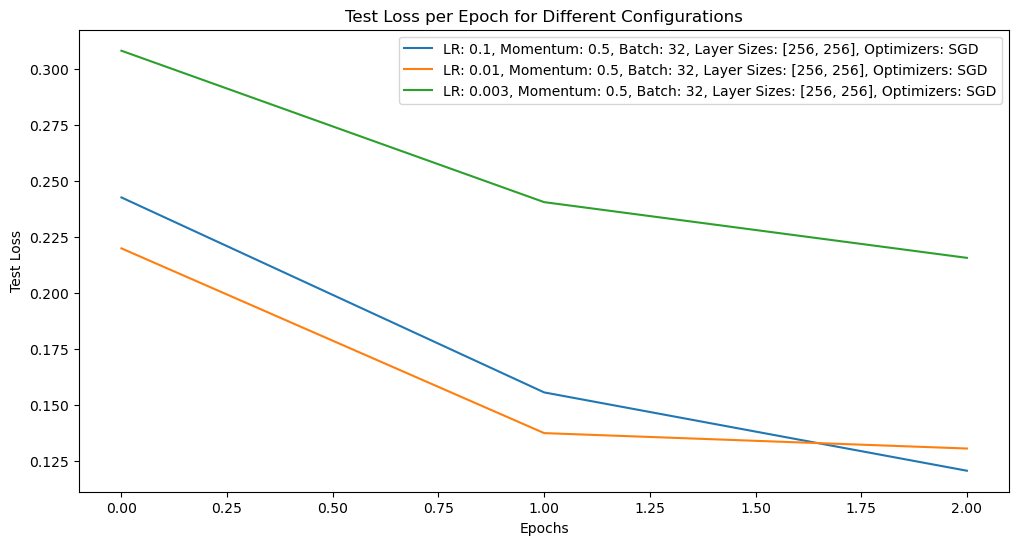

In [15]:
#1 Find the best learning rates 

learning_rates = [0.1, 0.01, 0.003]
momentums = [0.5]
batch_sizes = [32]
layer_configurations = [[256, 256]]
optimizers_list = [optimizers.legacy.SGD]
EPOCHS = 3

# Record results
experiment_results = []


for lr in learning_rates:
    for momentum in momentums:
        for batch_size in batch_sizes:
            for layer_sizes in layer_configurations:
                for opt in optimizers_list:
                    print(f"Running experiment with LR: {lr}, Momentum: {momentum}, Batch Size: {batch_size}, Layer Sizes: {layer_sizes}, Optimizer: {opt.__name__}")

                    train_dataset = data_pipeline(train_ds, batch_size)
                    test_dataset = data_pipeline(test_ds, batch_size)
                    
                    model = MLPModel(layer_sizes)


                    if opt == optimizers.legacy.SGD:
                        optimizer = opt(learning_rate=lr, momentum=momentum)
                    else:
                        optimizer = opt(learning_rate=lr)

                    cce = tf.keras.losses.CategoricalCrossentropy()

                    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                        EPOCHS, model, train_dataset, test_dataset, cce, optimizer, layer_sizes
                    )

                    experiment_results.append({
                        'lr': lr,
                        'momentum': momentum,
                        'batch_size': batch_size,
                        'layer_sizes': layer_sizes,
                        'optimizer': opt.__name__,
                        'train_losses': train_losses,
                        'test_losses': test_losses,
                        'train_accuracies': train_accuracies,
                        'test_accuracies': test_accuracies
                    })

results_df = pd.DataFrame(experiment_results)





results_df = pd.DataFrame(experiment_results)
print("Summary Statistics:")
print(results_df[['train_losses', 'test_losses', 'train_accuracies', 'test_accuracies']].describe())

# Best accuracy
best_accuracy = results_df.sort_values(by='test_accuracies', ascending=False).head(1)
print("\nBest Accuracy Configuration:")
print(best_accuracy)

# Lowest loss
lowest_loss = results_df.sort_values(by='test_losses').head(1)
print("\nLowest Loss Configuration:")
print(lowest_loss)

# Plotting Test Losses for different configurations
plt.figure(figsize=(12, 6))
for index, row in results_df.iterrows():
    label = f"LR: {row['lr']}, Momentum: {row['momentum']}, Batch: {row['batch_size']}, Layer Sizes: {row['layer_sizes']}, Optimizers: {row['optimizer']}"
    plt.plot(row['test_losses'], label=label)
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Test Loss per Epoch for Different Configurations')
plt.legend()
plt.show()




In [1]:
#2 Find the best momentum
learning_rates = [0.01] # we found the best learning rates from last experiments
momentums = [0.1, 0.2, 0.5, 0.9, 0.95]
batch_sizes = [32]
layer_configurations = [[256, 256]]
optimizers_list = [optimizers.legacy.SGD]
EPOCHS = 3

# Record results
experiment_results = []


for lr in learning_rates:
    for momentum in momentums:
        for batch_size in batch_sizes:
            for layer_sizes in layer_configurations:
                for opt in optimizers_list:
                    print(f"Running experiment with LR: {lr}, Momentum: {momentum}, Batch Size: {batch_size}, Layer Sizes: {layer_sizes}, Optimizer: {opt.__name__}")

                    train_dataset = data_pipeline(train_ds, batch_size)
                    test_dataset = data_pipeline(test_ds, batch_size)
                    
                    model = MLPModel(layer_sizes)


                    if opt == optimizers.legacy.SGD:
                        optimizer = opt(learning_rate=lr, momentum=momentum)
                    else:
                        optimizer = opt(learning_rate=lr)

                    cce = tf.keras.losses.CategoricalCrossentropy()

                    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                        EPOCHS, model, train_dataset, test_dataset, cce, optimizer, layer_sizes
                    )

                    experiment_results.append({
                        'lr': lr,
                        'momentum': momentum,
                        'batch_size': batch_size,
                        'layer_sizes': layer_sizes,
                        'optimizer': opt.__name__,
                        'train_losses': train_losses,
                        'test_losses': test_losses,
                        'train_accuracies': train_accuracies,
                        'test_accuracies': test_accuracies
                    })

results_df = pd.DataFrame(experiment_results)





results_df = pd.DataFrame(experiment_results)
print("Summary Statistics:")
print(results_df[['train_losses', 'test_losses', 'train_accuracies', 'test_accuracies']].describe())

# Best accuracy
best_accuracy = results_df.sort_values(by='test_accuracies', ascending=False).head(1)
print("\nBest Accuracy Configuration:")
print(best_accuracy)

# Lowest loss
lowest_loss = results_df.sort_values(by='test_losses').head(1)
print("\nLowest Loss Configuration:")
print(lowest_loss)
# Plotting Test Losses for different configurations
plt.figure(figsize=(12, 6))
for index, row in results_df.iterrows():
    label = f"LR: {row['lr']}, Momentum: {row['momentum']}, Batch: {row['batch_size']}, Layer Sizes: {row['layer_sizes']}, Optimizers: {row['optimizer']}"
    plt.plot(row['test_losses'], label=label)
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Test Loss per Epoch for Different Configurations')
plt.legend()
plt.show()


NameError: name 'optimizers' is not defined

Running experiment with LR: 0.01, Momentum: 0.9, Batch Size: 32, Layer Sizes: [128, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.28997552394866943, Train Accuracy: 0.9088166666666667,
 Test Loss: 0.15842512249946594, Test Accuracy: 0.9512
Epoch 2,
 Train Loss: 0.1351511925458908, Train Accuracy: 0.9585333333333333,
 Test Loss: 0.11578037589788437, Test Accuracy: 0.9638
Epoch 3,
 Train Loss: 0.1018177717924118, Train Accuracy: 0.9676166666666667,
 Test Loss: 0.10133575648069382, Test Accuracy: 0.9674
Epoch 4,
 Train Loss: 0.08080073446035385, Train Accuracy: 0.9745,
 Test Loss: 0.08501278609037399, Test Accuracy: 0.9744
Epoch 5,
 Train Loss: 0.06664471328258514, Train Accuracy: 0.9789666666666667,
 Test Loss: 0.09085136651992798, Test Accuracy: 0.9716
Epoch 6,
 Train Loss: 0.054319076240062714, Train Accuracy: 0.9820166666666666,
 Test Loss: 0.0831935778260231, Test Accuracy: 0.9752
Epoch 7,
 Train Loss: 0.04743906483054161, Train Accuracy: 0.9848833333333333,
 Test Loss: 0.093395151197

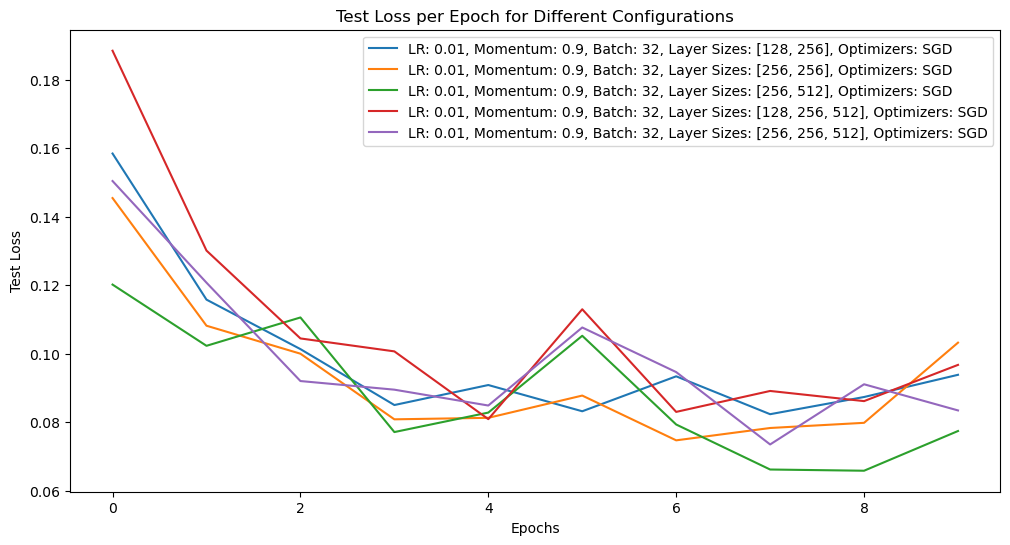

In [17]:
#3 Experiment with Different layer sizes 
learning_rates = [0.01] 
momentums = [0.9] # we found the best learning rates from last experiments
batch_sizes = [32]
layer_configurations = [[128, 256], [256, 256], [256, 512], [128,256,512], [256, 256, 512]]
optimizers_list = [optimizers.legacy.SGD]
EPOCHS = 10

# Record results
experiment_results = []


for lr in learning_rates:
    for momentum in momentums:
        for batch_size in batch_sizes:
            for layer_sizes in layer_configurations:
                for opt in optimizers_list:
                    print(f"Running experiment with LR: {lr}, Momentum: {momentum}, Batch Size: {batch_size}, Layer Sizes: {layer_sizes}, Optimizer: {opt.__name__}")

                    train_dataset = data_pipeline(train_ds, batch_size)
                    test_dataset = data_pipeline(test_ds, batch_size)
                    
                    model = MLPModel(layer_sizes)


                    if opt == optimizers.legacy.SGD:
                        optimizer = opt(learning_rate=lr, momentum=momentum)
                    else:
                        optimizer = opt(learning_rate=lr)

                    cce = tf.keras.losses.CategoricalCrossentropy()

                    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                        EPOCHS, model, train_dataset, test_dataset, cce, optimizer, layer_sizes
                    )

                    experiment_results.append({
                        'lr': lr,
                        'momentum': momentum,
                        'batch_size': batch_size,
                        'layer_sizes': layer_sizes,
                        'optimizer': opt.__name__,
                        'train_losses': train_losses,
                        'test_losses': test_losses,
                        'train_accuracies': train_accuracies,
                        'test_accuracies': test_accuracies
                    })

results_df = pd.DataFrame(experiment_results)





results_df = pd.DataFrame(experiment_results)
print("Summary Statistics:")
print(results_df[['train_losses', 'test_losses', 'train_accuracies', 'test_accuracies']].describe())

# Best accuracy
best_accuracy = results_df.sort_values(by='test_accuracies', ascending=False).head(1)
print("\nBest Accuracy Configuration:")
print(best_accuracy)

# Lowest loss
lowest_loss = results_df.sort_values(by='test_losses').head(1)
print("\nLowest Loss Configuration:")
print(lowest_loss)
# Plotting Test Losses for different configurations
plt.figure(figsize=(12, 6))
for index, row in results_df.iterrows():
    label = f"LR: {row['lr']}, Momentum: {row['momentum']}, Batch: {row['batch_size']}, Layer Sizes: {row['layer_sizes']}, Optimizers: {row['optimizer']}"
    plt.plot(row['test_losses'], label=label)
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Test Loss per Epoch for Different Configurations')
plt.legend()
plt.show()




## 3-4 Experiment with Different Optimizers
////here need to write our findings

Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.36094173789024353, Train Accuracy: 0.8929166666666667,
 Test Loss: 0.20361748337745667, Test Accuracy: 0.9409
Epoch 2,
 Train Loss: 0.1825351119041443, Train Accuracy: 0.9458833333333333,
 Test Loss: 0.14663752913475037, Test Accuracy: 0.9567
Epoch 3,
 Train Loss: 0.13315433263778687, Train Accuracy: 0.95995,
 Test Loss: 0.1177024096250534, Test Accuracy: 0.9652
Epoch 4,
 Train Loss: 0.10572190582752228, Train Accuracy: 0.9684166666666667,
 Test Loss: 0.1131749227643013, Test Accuracy: 0.9646
Epoch 5,
 Train Loss: 0.08796217292547226, Train Accuracy: 0.9738833333333333,
 Test Loss: 0.09255953878164291, Test Accuracy: 0.9724
Epoch 6,
 Train Loss: 0.0750279575586319, Train Accuracy: 0.9777166666666667,
 Test Loss: 0.08268984407186508, Test Accuracy: 0.9748
Epoch 7,
 Train Loss: 0.0647500529885292, Train Accuracy: 0.9806,
 Test Loss: 0.07497052848339081, Test Ac

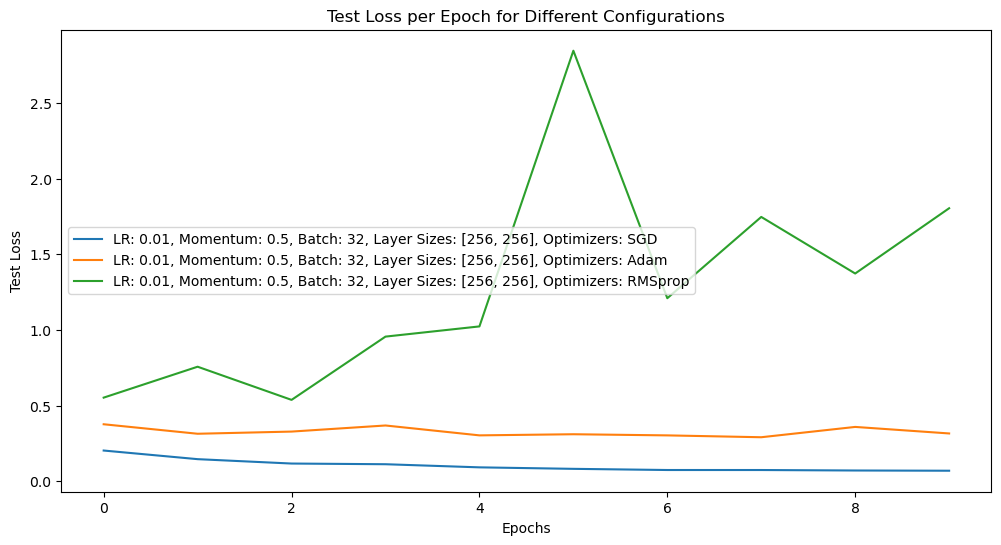

In [20]:

# 4 Experiment with Different Optimizers
learning_rates = [0.01] # we found the best learning rates from last experiments
momentums = [0.5]
batch_sizes = [32]
layer_configurations = [[256, 256]]
optimizers_list = [optimizers.legacy.SGD, optimizers.legacy.Adam, optimizers.legacy.RMSprop]
EPOCHS = 10

# Record results
experiment_results = []


for lr in learning_rates:
    for momentum in momentums:
        for batch_size in batch_sizes:
            for layer_sizes in layer_configurations:
                for opt in optimizers_list:
                    print(f"Running experiment with LR: {lr}, Momentum: {momentum}, Batch Size: {batch_size}, Layer Sizes: {layer_sizes}, Optimizer: {opt.__name__}")

                    train_dataset = data_pipeline(train_ds, batch_size)
                    test_dataset = data_pipeline(test_ds, batch_size)
                    
                    model = MLPModel(layer_sizes)


                    if opt == optimizers.legacy.SGD:
                        optimizer = opt(learning_rate=lr, momentum=momentum)
                    else:
                        optimizer = opt(learning_rate=lr)

                    cce = tf.keras.losses.CategoricalCrossentropy()

                    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                        EPOCHS, model, train_dataset, test_dataset, cce, optimizer, layer_sizes
                    )

                    experiment_results.append({
                        'lr': lr,
                        'momentum': momentum,
                        'batch_size': batch_size,
                        'layer_sizes': layer_sizes,
                        'optimizer': opt.__name__,
                        'train_losses': train_losses,
                        'test_losses': test_losses,
                        'train_accuracies': train_accuracies,
                        'test_accuracies': test_accuracies
                    })

results_df = pd.DataFrame(experiment_results)





results_df = pd.DataFrame(experiment_results)
print("Summary Statistics:")
print(results_df[['train_losses', 'test_losses', 'train_accuracies', 'test_accuracies']].describe())

# Best accuracy
best_accuracy = results_df.sort_values(by='test_accuracies', ascending=False).head(1)
print("\nBest Accuracy Configuration:")
print(best_accuracy)

# Lowest loss
lowest_loss = results_df.sort_values(by='test_losses').head(1)
print("\nLowest Loss Configuration:")
print(lowest_loss)
# Plotting Test Losses for different configurations
plt.figure(figsize=(12, 6))
for index, row in results_df.iterrows():
    label = f"LR: {row['lr']}, Momentum: {row['momentum']}, Batch: {row['batch_size']}, Layer Sizes: {row['layer_sizes']}, Optimizers: {row['optimizer']}"
    plt.plot(row['test_losses'], label=label)
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Test Loss per Epoch for Different Configurations')
plt.legend()
plt.show()



